<a href="https://colab.research.google.com/github/alex-bolshunov/data_mining_project/blob/main/data_mining_project_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc

In [ ]:
!curl "https://raw.githubusercontent.com/alex-bolshunov/data_mining_project/refs/heads/main/df.csv" -o df.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7309  100  7309    0     0  31485      0 --:--:-- --:--:-- --:--:-- 31504


In [ ]:
df = pd.read_csv("df.csv").set_index("state").drop(["state_full", "od.ratio", "od.group"], axis = 1)

In [ ]:
df["od.group2"] = df["od.group2"].apply(lambda x: 1 if x == "high" else 0)

In [ ]:
df.head()

,pop,od,specialty,credentials,opioid,controlled,not.opioid,OXYCONTIN,OXYCODONE.HCL,OXYCODONE.ACETAMINOPHEN,...,MORPHINE.SULFATE,TRAMADOL.HCL,HYDROMORPHONE.HCL,HYDROCODONE.ACETAMINOPHEN,CLONAZEPAM,METHADONE.HCL,FENTANYL,MORPHINE.SULFATE.ER,DIAZEPAM,od.group2
state,,,,,,,,,,,,,,,,,,,,,
AK,735132,124,14,11,1499,417,14094,31,217,87,...,11,118,84,430,131,69,41,157,90,1
AL,4833722,723,42,39,72163,30984,808083,716,1641,4001,...,488,15264,222,34560,8199,709,1738,1100,1983,0
AR,2959373,356,40,35,38164,14237,380792,364,2065,2475,...,193,5433,235,16788,5016,573,941,1174,2186,0
AZ,6626624,1211,59,65,57947,17897,493060,1678,8526,8770,...,958,7284,728,16095,3318,1032,1436,5101,1845,1
CA,38332521,4521,79,149,223722,105421,2796825,3351,6748,11723,...,1471,30379,2996,110347,19223,4012,5677,8313,8884,0


In [ ]:
split_col_num = 21

In [ ]:
X = df.iloc[:, :split_col_num].values
y = df.iloc[:, split_col_num:].values

In [ ]:
standard_scaler = preprocessing.StandardScaler() #assumes your data is normally distributed within each feature
min_max_scaler = preprocessing.MinMaxScaler() #0 - 1, if not normal, susceptible for outliers
robust_scaler = preprocessing.RobustScaler() #uses interquartile range, not susceptible for outliers

In [ ]:
#function to find the best value of k

def get_knn_metrics_df(X_tr, X_tt, y_tr, y_tt):
  metrics_list = []

  for i in range(1,len(X_tr) + 1):
    knn = KNeighborsClassifier(n_neighbors= i)
    knn.fit(X_tr, y_tr)
    y_pred = knn.predict(X_tt)
    metrics_inst = (i, accuracy_score(y_tt, y_pred), precision_score(y_tt, y_pred, average = "macro"), recall_score(y_tt, y_pred, average = "macro"))
    metrics_list.append(metrics_inst)

  return pd.DataFrame(metrics_list, columns = ["k", "accuracy", "precision", "recall"])

In [ ]:
#plot metrics plot
def compare_metrics_plot(df, title = "", colors = ["blue", "red", "green"]):
  plt.cla()
  plt.plot(df.loc[:, "k"], df.loc[:, "accuracy"], label = "Accuracy", color = colors[1])
  plt.plot(df.loc[:, "k"], df.loc[:, "precision"], label = "Precision", color = colors[0])
  plt.plot(df.loc[:, "k"], df.loc[:, "recall"], label = "Recall", color = colors[2])
  plt.xlabel("K-value")
  plt.ylabel("Metrics")
  plt.grid(alpha = 0.6)
  plt.legend()
  plt.title(title)
  plt.show();

In [ ]:
#show predicted and actual
def best_value_knn(k, X_tr, X_tt, y_tr, y_tt):
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_tr, y_tr)
  y_pred = knn.predict(X_tt)
  return pd.DataFrame({"actual": y_tt, "predicted": y_pred, "result": y_tt == y_pred}).T

In [ ]:
def auc_best_value_knn_df(X_tr, X_tt, y_tr, y_tt):
  metrics_list = []

  for i in range(1,len(X_tr) + 1):
    knn = KNeighborsClassifier(n_neighbors= i)
    knn.fit(X_tr, y_tr)
    probs = knn.predict_proba(X_tt)[:, 1]
    fpr, tpr, thresholds =  roc_curve(y_tt, probs)
    metrics_list.append((i, auc(fpr, tpr)))

  return pd.DataFrame(metrics_list, columns = ["k", "auc"]).set_index("k")

In [ ]:
def roc_curve_plot(k, X_tr, X_tt, y_tr, y_tt, title = ""):
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_tr, y_tr)
  probs = knn.predict_proba(X_tt)[:, 1]
  fpr, tpr, thresholds =  roc_curve(y_tt, probs)
  roc_auc = auc(fpr, tpr)

  plt.cla()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.fill_between(fpr, tpr, 0, color='lightblue')
  plt.plot([0, 1], [0, 1], 'grey')  # Diagonal line for random classifier
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve ' + title)
  plt.legend(loc='lower right')
  plt.grid(alpha = 0.5)
  plt.show()

In [ ]:
#all values without scaling
def split_and_reshape(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
  return X_train, X_test, y_train.reshape(-1), y_test.reshape(-1)

In [ ]:
xtr_ns, xtt_ns, ytr_ns, ytt_ns = split_and_reshape(X, y)

In [ ]:
not_scaled_metrics_df = get_knn_metrics_df(xtr_ns, xtt_ns, ytr_ns, ytt_ns)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

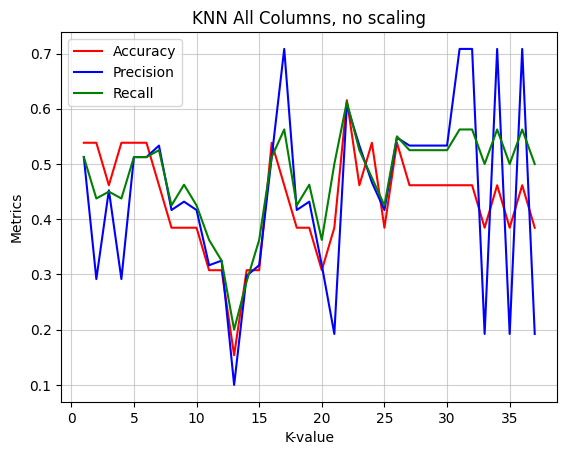

In [ ]:
compare_metrics_plot(not_scaled_metrics_df, title = "KNN All Columns, no scaling")

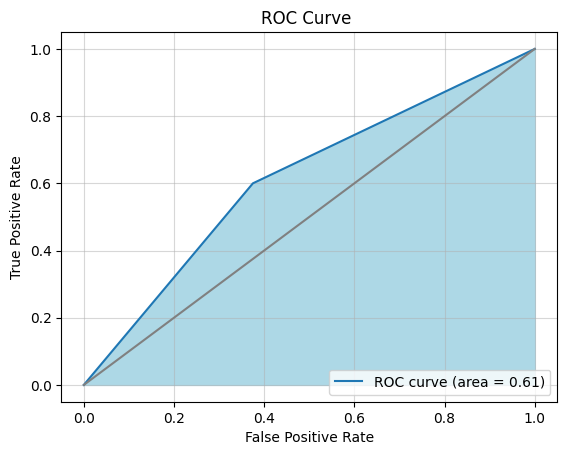

In [ ]:
roc_curve_plot(22, xtr_ns, xtt_ns, ytr_ns, ytt_ns)

In [ ]:
best_value_knn(22, xtr_ns, xtt_ns, ytr_ns, ytt_ns)

,0,1,2,3,4,5,6,7,8,9,10,11,12
actual,0,0,0,0,1,1,0,0,1,1,0,0,1
predicted,0,0,0,1,0,1,0,1,1,1,1,0,0
result,True,True,True,False,False,True,True,False,True,True,False,True,False


In [ ]:
X_robust = robust_scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_robust, y, test_size=0.25, random_state=42)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
robust_metrics_df = get_knn_metrics_df(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

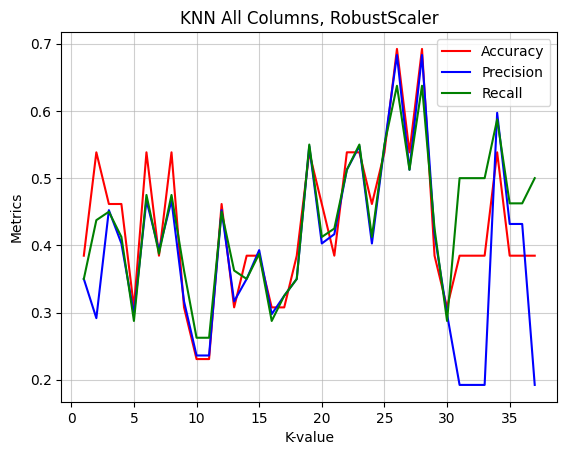

In [ ]:
compare_metrics_plot(robust_metrics_df, title = "KNN All Columns, RobustScaler")

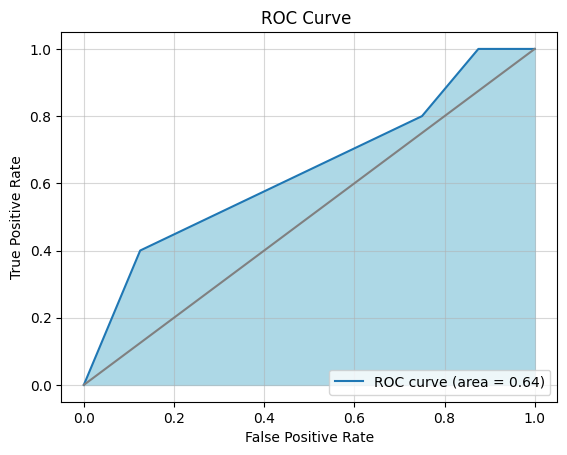

In [ ]:
roc_curve_plot(26, X_train, X_test, y_train, y_test)

In [ ]:
best_value_knn(26, X_train, X_test, y_train, y_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12
actual,0,0,0,0,1,1,0,0,1,1,0,0,1
predicted,0,0,1,0,1,0,0,0,0,1,0,0,0
result,True,True,False,True,True,False,True,True,False,True,True,True,False


In [ ]:
Xd = df.loc[:, df.columns[8:21]].values
yd = df.iloc[:, 21:].values

In [ ]:
X_tr, X_tt, y_tr, y_tt = train_test_split(Xd, yd, test_size=0.25, random_state=42)
y_tr = y_tr.reshape(-1)
y_tt = y_tt.reshape(-1)

In [ ]:
drugs_metrics_df = get_knn_metrics_df(X_tr, X_tt, y_tr, y_tt)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


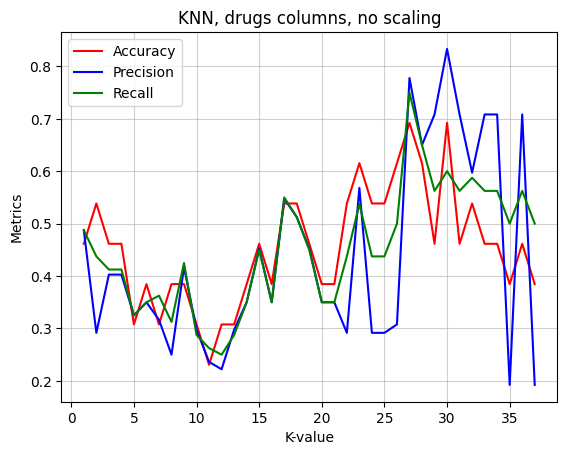

In [ ]:
compare_metrics_plot(drugs_metrics_df, title = "KNN, drugs columns, no scaling")

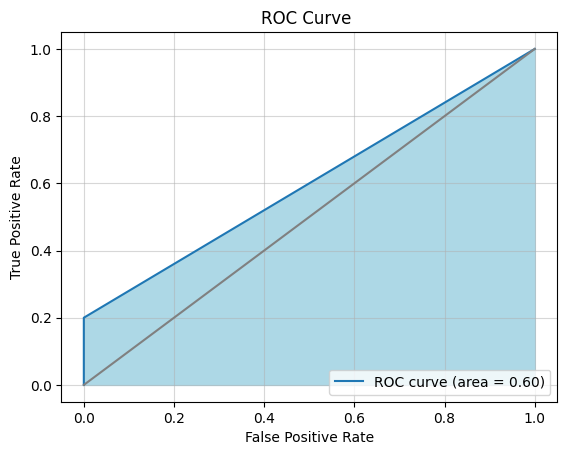

In [ ]:
roc_curve_plot(30, X_tr, X_tt, y_tr, y_tt)

In [ ]:
best_value_knn(30, X_tr, X_tt, y_tr, y_tt)

,0,1,2,3,4,5,6,7,8,9,10,11,12
actual,0,0,0,0,1,1,0,0,1,1,0,0,1
predicted,0,0,0,0,1,0,0,0,0,0,0,0,0
result,True,True,True,True,True,False,True,True,False,False,True,True,False


In [ ]:
df.head()

,pop,od,specialty,credentials,opioid,controlled,not.opioid,OXYCONTIN,OXYCODONE.HCL,OXYCODONE.ACETAMINOPHEN,...,MORPHINE.SULFATE,TRAMADOL.HCL,HYDROMORPHONE.HCL,HYDROCODONE.ACETAMINOPHEN,CLONAZEPAM,METHADONE.HCL,FENTANYL,MORPHINE.SULFATE.ER,DIAZEPAM,od.group2
state,,,,,,,,,,,,,,,,,,,,,
AK,735132,124,14,11,1499,417,14094,31,217,87,...,11,118,84,430,131,69,41,157,90,1
AL,4833722,723,42,39,72163,30984,808083,716,1641,4001,...,488,15264,222,34560,8199,709,1738,1100,1983,0
AR,2959373,356,40,35,38164,14237,380792,364,2065,2475,...,193,5433,235,16788,5016,573,941,1174,2186,0
AZ,6626624,1211,59,65,57947,17897,493060,1678,8526,8770,...,958,7284,728,16095,3318,1032,1436,5101,1845,1
CA,38332521,4521,79,149,223722,105421,2796825,3351,6748,11723,...,1471,30379,2996,110347,19223,4012,5677,8313,8884,0


In [ ]:
#scaled
X = df.loc[:, ["specialty", "opioid", "not.opioid"]].values
X = robust_scaler.fit_transform(X)
y = df.iloc[:, 21:].values

In [ ]:
X_train, X_test, y_train, y_test = split_and_reshape(X, y)

In [ ]:
soodf =  get_knn_metrics_df(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

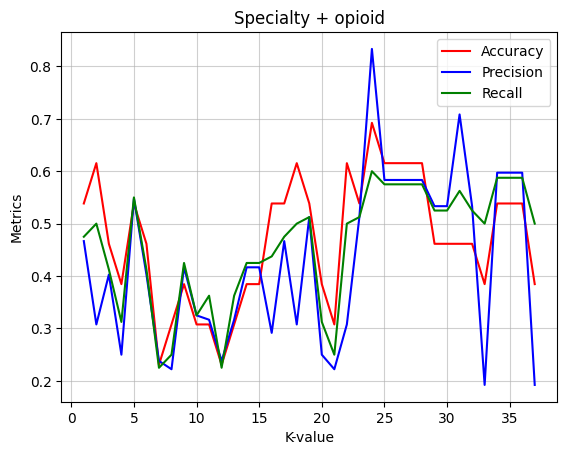

In [ ]:
compare_metrics_plot(soodf, title = "Specialty + opioid")

In [ ]:
auc_df = auc_best_value_knn_df(X_train, X_test, y_train, y_test)

In [ ]:
auc_df.loc[:, "auc"].idxmax()

28

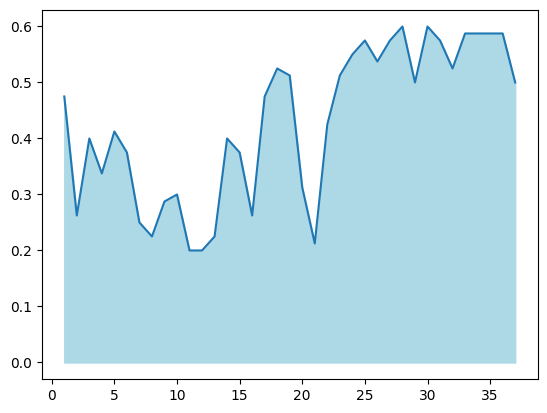

In [ ]:
plt.plot(auc_df.index, auc_df.loc[:, "auc"])
plt.fill_between(auc_df.index, auc_df.loc[:, "auc"], 0, color='lightblue')

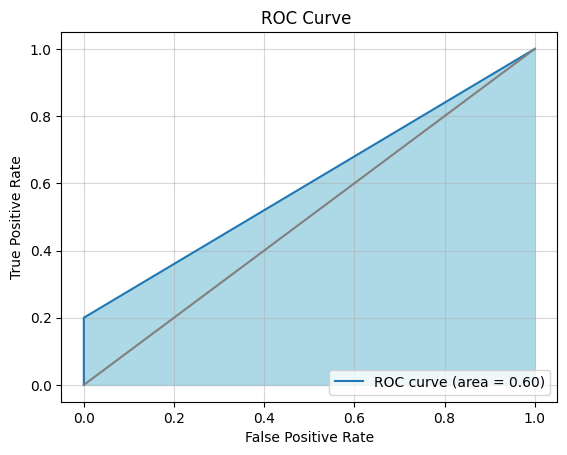

In [ ]:
roc_curve_plot(28, X_train, X_test, y_train, y_test)

In [ ]:
best_value_knn(28, X_train, X_test, y_train, y_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12
actual,0,0,0,0,1,1,0,0,1,1,0,0,1
predicted,0,1,1,0,1,0,0,0,0,1,0,0,0
result,True,False,False,True,True,False,True,True,False,True,True,True,False


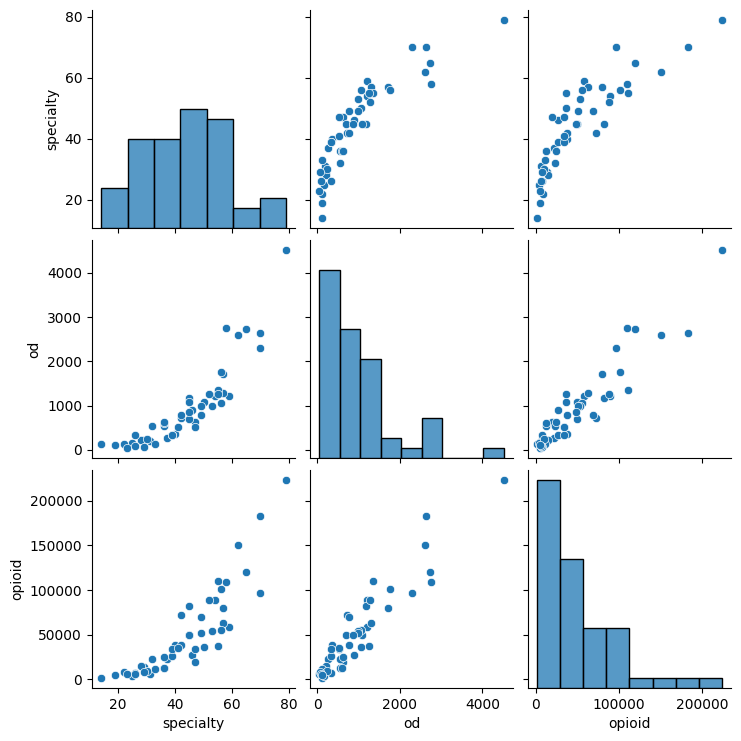

In [ ]:
sns.pairplot(df.loc[:, ["specialty", "od", "opioid"]])